# Setup

`TRAINING_RANGE` und `TEST_RANGE` müssen je nach Länge des Datensatzes angepasst werden.

**Keine Anpassung erforderlich** (Siehe Datensatz herunterladen)
- 30% Training-Daten (0-30%)
- 70% Test-Daten (30%-100%)

In [1]:
INPUT_FILE = 'data.csv'
TARGET_COLUMN = 'flt_obd_speed'
# Still contains positional information and acceleration; however we currently train
# sample by sample without knowledge of previous or other data, so it should not be
# possible for the Regressor to simply "calculate" the speed.
EXCLUDED_COLUMNS = ('flt_gps_speed', 'flt_obd_engine_load', 'flt_obd_engine_rpm',
                    'flt_obd_maf', 'flt_obd_accelerator_pedal','flt_time','flt_time_system_clock',
                    'flt_time_utc','flt_ax','flt_ay','flt_az','flt_gx','flt_gy','flt_gz','flt_compass',
                    'flt_number_of_satelites','flt_accuracy','flt_gps_bearing','flt_calc_dist_gps',
                    'flt_calc_dist_vt','flt_calc_ax_vt','flt_timeIP',
                    'weat_latitude','weat_longitude','weat_distanceIP','weat_timeIP','weat_join_idx',
                    'hAccel_1','hAccel_2','hAccel_3','flt_mAccel_1','flt_mAccel_2','flt_mAccel_3',
                    'flt_mGier_1','flt_mGier_2','flt_mGier_3','rot_Accel_1','rot_Accel_2','rot_Accel_3',
                    'rot_Gier_1','rot_Gier_2','rot_Gier_3','rot_Accel_flt_1','rot_Accel_flt_2','rot_Accel_flt_3',
                    'rot_Gier_flt_1','rot_Gier_flt_2','rot_Gier_flt_3'
                   )
# See explanation below the feature importance plot
OVERFITTING_COLUMNS = ('weat_temperature', 'weat_humidity', 'join_idx', 'weat_windBearing', 'weat_windSpeed',
                       'latitude', 'longitude', 'flt_latitude', 'flt_longitude',
                       'ors_percentage_cumsum', 'flt_obd_air_temperature',
                       'mb_step_weight')
# Since there are a lot of fields containing those
# Note: This breaks the map plotting
OVERFITTING_SUBWORDS = ('distance', 'remainDistance', 'remainDistanze', 'cumsumDistance', 'segDistance', 'time', 'remainTime')

from runsql import runsql
DATA_COLUMNS = [c['Field']
                for c in runsql('show columns from computeddata')
                if c['Type'] == 'double'
                and c['Field'] != TARGET_COLUMN
                and c['Field'] not in EXCLUDED_COLUMNS
                and c['Field'] not in OVERFITTING_COLUMNS
                and not any([w in c['Field'] for w in OVERFITTING_SUBWORDS])]
len(DATA_COLUMNS)
print(DATA_COLUMNS)

['curvature', 'radius', 'phiSegment', 'flt_DB_counter', 'flt_setup_id', 'flt_altitude', 'flt_go_elevation', 'flt_go_eleResolution', 'flt_osm_trafficSignal', 'flt_osm_w_wood', 'flt_join_idx', 'flt_curvature', 'flt_radius', 'flt_phiSegment', 'hr_latitude', 'hr_longitude', 'hr_elevation', 'hr_SpeedLimit', 'hr_LinkID', 'hr_shapeFirstPoint', 'hr_shapeLastPoint', 'hr_lengthSegemnt', 'hr_actualManeuver', 'hr_traficSpeed', 'hr_traficTime', 'hr_baseSpeed', 'hr_baseTime', 'hr_JamFactor', 'hr_FunctionalRoadClass', 'hr_consumption', 'hr_mTravelTime', 'hr_mLenght', 'hr_mFirstPoint', 'hr_mLastPoint', 'hr_mNextManeuver', 'hr_mTrafficTime', 'hr_mStartAngle', 'hr_leg_firtPoint', 'hr_leg_lastPoint', 'hr_leg_length', 'hr_leg_travelTime', 'hr_leg_trafficTime', 'hr_leg_baseTime', 'hr_leg_spot', 'hr_leg_shapeIndex', 'hr_IdxNP', 'hr_NearestPoint_1', 'hr_NearestPoint_2', 'hr_PointOnRoute_1', 'hr_PointOnRoute_2', 'hr_Dist2Origin', 'hr_Dist2Route', 'hr_osm_trafficSignal', 'hr_osm_w_wood', 'hr_join_idx', 'hr_cur

In [2]:
DECISION_TREE_IMPORTANT = ('gh_avgspeed', 'mq_avgspeed', 'osm_w_maxspeed', 'hr_traficSpeed', 'bg_avgspeed_leg',
                          'mb_seg_speed', 'osm_w_maxspeed_new', 'hr_baseSpeed', 'hr_SpeedLimit', 'gh_elevation',
                          'ors_seg_speed', 'osm_w_lanes', 'osrm_step_weight', 'mb_seg_speed_calc', 'hr_elevation',
                          'bg_avgspeed', 'osrm_seg_speed', 'bg_avgspeed_subleg', 'go_mean_velocity_calc_pre', 'mb_i_laneNumber',
                          'osrm_i_entry_1', 'ors_long_speed', 'mb_radius', 'ei_avgspeed', )#'flt_DB_counter') # overfitting -.-

# Datensatz herunterladen

`SETUP_ID` anpassen, Rest läuft automatisch

In [3]:
SETUP_ID = 868
import csv
from runsql import runsql
reader = runsql('select * from computeddata where setup_id = {} order by distance asc'.format(SETUP_ID))
reader_data = list(reader) # list(...) so that following cells can be repeated

In [4]:
import math
data = []
target = []
for row in reader_data:
    data += [[float(row[c]) if row[c] != '' else math.nan for c in DATA_COLUMNS]]
    target += [float(row[TARGET_COLUMN])] # Errors if NaN in TARGET_COLUMN

In [5]:
tr_st = 0
tr_ed = math.floor(len(data)*0.3)
TRAINING_RANGE = (tr_st, tr_ed)
TEST_RANGE = (tr_ed, len(data)) # TEST_RANGE = (len(data)-tr_ed, len(data))

# Leere Zellen füllen

Da nicht alle Datensätze alle Spalten haben – gäbe sicherlich bessere Strategien, aber das funktioniert erstaunlich gut (wahrscheinlich sind die "wichtigen" Spalten immer vorhanden).

In [6]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='constant', fill_value=0) # Other strategies remove fully null columns
data = imp.fit_transform(data)
import numpy as np
np.shape(data)

(7228, 311)

CSV-Export, für MATLAB o.Ä.

In [7]:
np.savetxt('imputed-{}.csv'.format(SETUP_ID), data, delimiter=',')
np.savetxt('target-{}.csv'.format(SETUP_ID), target, delimiter=',')

# Analyze INPUT DATA
Eingangsdaten analysieren

In [8]:
# Convert to Table
import sys
from astropy.table import Table
t = Table(data, names=DATA_COLUMNS)
#lat = t['latitude']
#lng = t['longitude']
# Subsampling ... use points every 50m for plotting
#lat = lat[::10]
#lng = lng[::10]

# determine range to print based on min, max lat and lon of the data
#margin = 0 # buffer to add to the range
#lat_min = min(lat) - margin
#lat_max = max(lat) + margin
#lon_min = min(lng) - margin
#lon_max = max(lng) + margin
t

ModuleNotFoundError: No module named 'astropy'

In [9]:
# Calculation ZOOM LEVEL
width  = 640
height = 640
tileSize= 256*4

# Converts given lat/lon in WGS84 Datum to XY in Spherical Mercator EPSG:900913"
originShift = 2 * math.pi * 6378137/2.0; # 20037508.342789244
xExtent_min = lon_min * originShift / 180;
yExtent_min = math.log(math.tan((90 + lat_min) * math.pi / 360 )) / (math.pi / 180);
yExtent_min = yExtent_min * originShift / 180;
xExtent_max = lon_max * originShift / 180;
yExtent_max = math.log(math.tan((90 + lat_max) * math.pi / 360 )) / (math.pi / 180);
yExtent_max = yExtent_max * originShift / 180;

minResX = (xExtent_max-xExtent_min)/width;
minResY = (yExtent_max-yExtent_min)/height;
minRes  = max([minResX, minResY]);
initialResolution = 2 * math.pi * 6378137 / tileSize; # 156543.03392804062 for tileSize 256 pixels
zoomlevel = math.floor(math.log2(initialResolution/minRes));

# Enforce valid zoom levels
if zoomlevel < 0:
    zoomlevel = 0
if zoomlevel > 19: 
    zoomlevel = 19

NameError: name 'lon_min' is not defined

In [10]:
# Analyze Data
import plotly
import plotly.graph_objs as go
import plotly.plotly as py

plotly.tools.set_credentials_file(username='ziegmann', api_key='yGii8dk78Sjz7jzzad1n')
mapbox_access_token = 'pk.eyJ1Ijoiam9oYW5ubmVzLXppZWdtYW5uIiwiYSI6ImNqbDJmamo5bDFxNjQzcWxtd2IzejNhcXoifQ.iVXGH-jpe2FH3f52MM9yHQ'

data_p = [
    go.Scattermapbox(
        lat=lat,
        lon=lng,
        mode='markers',
        marker=dict(size=6))
]

layout = go.Layout(
    title='OBD-II GPS Logging',
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lon=(lon_max-lon_min)/2+lon_min,
            lat=(lat_max-lat_min)/2+lat_min,
        ),
        style='dark',
        pitch=0,
        zoom=zoomlevel
    ),
)

fig = dict(data=data_p, layout=layout)
#plotly.offline.plot(fig, filename='Mapbox.html')
py.iplot(fig, filename='Mapbox.html')

ModuleNotFoundError: No module named 'plotly'

In [11]:
import matplotlib.pyplot as plot
temp_d=t['distance']
xaxis = temp_d # range(int(temp_d[0]), int(temp_d[-1]))
plot.figure(figsize=(15,10))
plot.axvline(x=temp_d[TRAINING_RANGE[0]])
plot.axvline(x=temp_d[TEST_RANGE[0]])
plot.plot(temp_d[TEST_RANGE[0]:TEST_RANGE[1]], target[TEST_RANGE[0]:TEST_RANGE[1]], 'b',
          xaxis, t['hr_traficSpeed']*3.6, 'r',
          xaxis, t['hr_SpeedLimit'],
         )
plot.legend(['Training','Test','OBD Speed','HERE Traffic Speed', 'HERE Speed Limint'])

NameError: name 't' is not defined

# Training

Bei großen Datensätzen kann es zur Fehlerausgabe "UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak." kommen. Scheint vereinzelt am Ergebnis aber nicht viel zu ändern.

Es werden alle gegebenen Parameterkombinationen mittels Cross-Validation getestet; die besten für die Vorhersage verwendet und dann auch ausgegeben.

In [61]:
import tensorflow as tf
from tensorflow.keras import layers

model = tf.keras.Sequential([
    layers.Lambda(lambda x: x, batch_input_shape = (1, np.shape(data)[1], 1)), # Hacky No-op layer for reshaping
    layers.LSTM(256, stateful = True),
    layers.Dense(1)
])

model.compile(optimizer = tf.keras.optimizers.Adam(0.001),
             loss = 'mse',
             metrics = ['mae'])

In [62]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data[TRAINING_RANGE[0]:TRAINING_RANGE[1]])

scaled_training_data = scaler.transform(data[TRAINING_RANGE[0]:TRAINING_RANGE[1]])
scaled_data = scaler.transform(data)
scaled_target = np.multiply(target, 0.01)

In [63]:
#from sklearn.decomposition import PCA
#pca = PCA(n_components = 50)
#pca_training_data = pca.fit_transform(scaled_training_data)
#pca_data = pca.transform(scaled_data)
pca_training_data = scaled_training_data
pca_data = scaled_data

In [64]:
import numpy as np
model.fit(np.array(pca_training_data).reshape(*np.shape(pca_training_data), 1), np.array(scaled_target[TRAINING_RANGE[0]:TRAINING_RANGE[1]]).reshape(len(pca_training_data), 1),
          epochs = 4, batch_size = 1) # Seems to be the most common point of diminishing returns

Train on 2168 samples
Epoch 1/4
2168/2168 [==============================] - 187s 86ms/sample - loss: 0.1007 - mae: 0.2363
Epoch 2/4
2168/2168 [==============================] - 182s 84ms/sample - loss: 0.0789 - mae: 0.2323
Epoch 3/4
2168/2168 [==============================] - 183s 84ms/sample - loss: 0.0702 - mae: 0.2182
Epoch 4/4
2168/2168 [==============================] - 179s 82ms/sample - loss: 0.0423 - mae: 0.1636


# Testen und Plotten

Wenn mit anderem Datensatz getestet werden soll:
- Neuen Datensatz herunterladen und einlesen
- Eventuell `TEST_RANGE` anpassen
- Untere Zelle ausführen

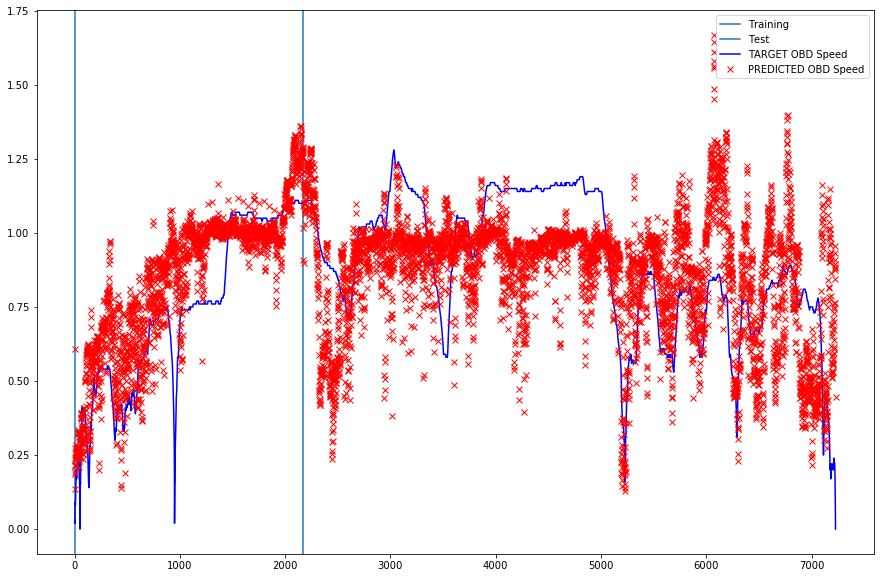

In [65]:
xaxis = range(0, TEST_RANGE[1])
plot.figure(figsize=(15,10))
plot.axvline(x=TRAINING_RANGE[0])
plot.axvline(x=TRAINING_RANGE[1])
from scipy.signal import savgol_filter
# savgol_filter for smoothing (params are window size and polynomial degree)
#plot.plot(xaxis, scaled_target, 'b', xaxis, savgol_filter(model.predict(pca_data.reshape(*np.shape(pca_data), 1)), 51, 3, axis=0), 'rx')
plot.plot(xaxis, scaled_target, 'b', xaxis, model.predict(pca_data.reshape(*np.shape(pca_data), 1)), 'rx')
plot.legend(['Training','Test','TARGET OBD Speed','PREDICTED OBD Speed'])
#len(savgol_filter(model.predict(pca_data).reshape(*np.shape(pca_data), 1), 51, 3, axis=0))

# Gütekriterium - Prädiktion

Berechung des Gütekritierums
- Root-mean-square deviation RMSE
- NRMSE Normalized root-mean-square deviation
- Mean absolute error MAE
- Mean absolute percentage error MAP
- Symmetric mean absolute percentage error
- https://en.wikipedia.org/wiki/Least_absolute_deviations
- https://en.wikipedia.org/wiki/Mean_signed_deviation
- Pearson Correlation Coefficient
- Accuracy (Interval of given size; absolute and relative)
- Media Absolute Deviation

BITTE weitere Kriterien ergänzen


In [66]:
ta = target[TEST_RANGE[0]:TEST_RANGE[1]]
pr = np.squeeze(np.multiply(model.predict(pca_data[TEST_RANGE[0]:TEST_RANGE[1]].reshape(TEST_RANGE[1]-TEST_RANGE[0], np.shape(pca_data)[1], 1)), 100))
RMSE = np.sqrt(sum((ta-pr)**2)/len(ta))
print("RMSE  = %.2f km/h" %RMSE)
NRMSE = 1-math.sqrt(sum((ta-pr)**2))/math.sqrt(sum( (ta-np.mean(ta) )**2 ))
print("NRMSE = %.2f %%" %(NRMSE*100))
MAE = sum(((ta-pr)**2)**(1/2))/len(ta)
print("MAE   = %.2f km/h" %MAE)
with np.errstate(divide = 'ignore'): map_elements = np.abs((ta - pr) / ta)
map_elements[map_elements == np.inf] = 0
MAP = np.sum(map_elements) / len(ta)
print("MAP   = %.2f %%" % (MAP*100))
SMAPE = np.sum(np.abs(ta - pr) / ((ta + pr) / 2)) / len(ta)
print("SMAPE = %.2f %%" % (SMAPE*100))
MSD = np.sum(ta - pr) / len(ta)
print("MSD   = %.2f km/h" % MSD)
CORR = np.corrcoef(ta, pr)[1][0]
print("CORR  = %.2f" % CORR)
ACC_A_THRESHOLD = 10
ACC_A = (np.abs(ta - pr) < ACC_A_THRESHOLD).sum() / len(ta)
print("ACC_A = %.2f %%" % (ACC_A*100))
ACC_R_THRESHOLD = 0.1
ACC_R = (np.abs(ta / pr - 1) < ACC_R_THRESHOLD).sum() / len(ta)
print("ACC_R = %.2f %%" % (ACC_R*100))
MAD = np.median(np.abs(ta - pr))
print("MAD   = %.2f km/h" % MAD)

RMSE  = 23.21 km/h
NRMSE = -1.11 %
MAE   = 19.08 km/h
MAP   = 25.80 %
SMAPE = 23.35 %
MSD   = 3.52 km/h
CORR  = 0.44
ACC_A = 27.94 %
ACC_R = 24.19 %
MAD   = 17.29 km/h


# Vergleich mit HERE Maps Trafic Speed
Kann zum Vergleich sehr gut herangezogen werden ;)

In [67]:
ta = target[TEST_RANGE[0]:TEST_RANGE[1]]
pr = [d['hr_traficSpeed'] for d in reader_data] #t['hr_traficSpeed']
pr = np.array([float(d) if d != '' else 0.0 for d in pr])
pr = pr[TEST_RANGE[0]:TEST_RANGE[1]] * 3.6
RMSE = math.sqrt(sum((ta-pr)**2)/len(ta))
print("RMSE  = %.2f km/h" %RMSE)
NRMSE = 1-math.sqrt(sum((ta-pr)**2))/math.sqrt(sum( (ta-np.mean(ta) )**2 ))
print("NRMSE = %.2f %%" %(NRMSE*100))
MAE = sum(((ta-pr)**2)**(1/2))/len(ta)
print("MAE   = %.2f km/h" %MAE)
with np.errstate(divide = 'ignore'): map_elements = np.abs((ta - pr) / ta)
map_elements[map_elements == np.inf] = 0
MAP = np.sum(map_elements) / len(ta)
print("MAP   = %.2f %%" % (MAP*100))
SMAPE = np.sum(np.abs(ta - pr) / ((ta + pr) / 2)) / len(ta)
print("SMAPE = %.2f %%" % (SMAPE*100))
MSD = np.sum(ta - pr) / len(ta)
print("MSD   = %.2f km/h" % MSD)
CORR = np.corrcoef(ta, pr)[1][0]
print("CORR  = %.2f" % CORR)
ACC_A_THRESHOLD = 10
ACC_A = (np.abs(ta - pr) < ACC_A_THRESHOLD).sum() / len(ta)
print("ACC_A = %.2f %%" % (ACC_A*100))
ACC_R_THRESHOLD = 0.1
ACC_R = (np.abs(ta / pr - 1) < ACC_R_THRESHOLD).sum() / len(ta)
print("ACC_R = %.2f %%" % (ACC_R*100))
MAD = np.median(np.abs(ta - pr))
print("MAD   = %.2f km/h" % MAD)

RMSE  = 16.82 km/h
NRMSE = 26.73 %
MAE   = 14.06 km/h
MAP   = 15.87 %
SMAPE = 16.62 %
MSD   = 9.82 km/h
CORR  = 0.81
ACC_A = 40.18 %
ACC_R = 32.00 %
MAD   = 12.84 km/h


# Generalisieren

In [68]:
model2 = tf.keras.Sequential([
    layers.Lambda(lambda x: x, batch_input_shape = (1, np.shape(data)[1], 1)), # Hacky No-op layer for reshaping
    layers.LSTM(256, stateful = True),
    layers.Dense(1)
])

model2.compile(optimizer = tf.keras.optimizers.Adam(0.001),
             loss = 'mse',
             metrics = ['mae'])

In [69]:
model2.fit(np.array(pca_data).reshape(*np.shape(pca_data), 1), np.array(scaled_target).reshape(len(pca_data), 1),
           epochs = 4, batch_size = 1)

Train on 7228 samples
Epoch 1/4
7228/7228 [==============================] - 609s 84ms/sample - loss: 0.0670 - mae: 0.1998
Epoch 2/4
7228/7228 [==============================] - 584s 81ms/sample - loss: 0.0729 - mae: 0.2219
Epoch 3/4
7228/7228 [==============================] - 576s 80ms/sample - loss: 0.0709 - mae: 0.2189
Epoch 4/4
7228/7228 [==============================] - 577s 80ms/sample - loss: 0.0690 - mae: 0.2162


In [75]:
SETUP_ID_2 = 450

reader2 = runsql('select * from computeddata where setup_id = {} order by distance asc'.format(SETUP_ID_2))
reader_data2 = list(reader2) # list(...) so that following cells can be repeated

In [76]:
data2 = []
target2 = []
for row in reader_data2:
    data2 += [[float(row[c]) if row[c] != '' else math.nan for c in DATA_COLUMNS]]
    target2 += [float(row[TARGET_COLUMN]) if row[TARGET_COLUMN] != '' else math.nan]

In [77]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='constant', fill_value=0) # Other strategies remove fully null columns
data2 = imp.fit_transform(data2)

In [78]:
scaled_data2 = scaler.transform(data2)
scaled_target2 = np.multiply(target2, 0.01)

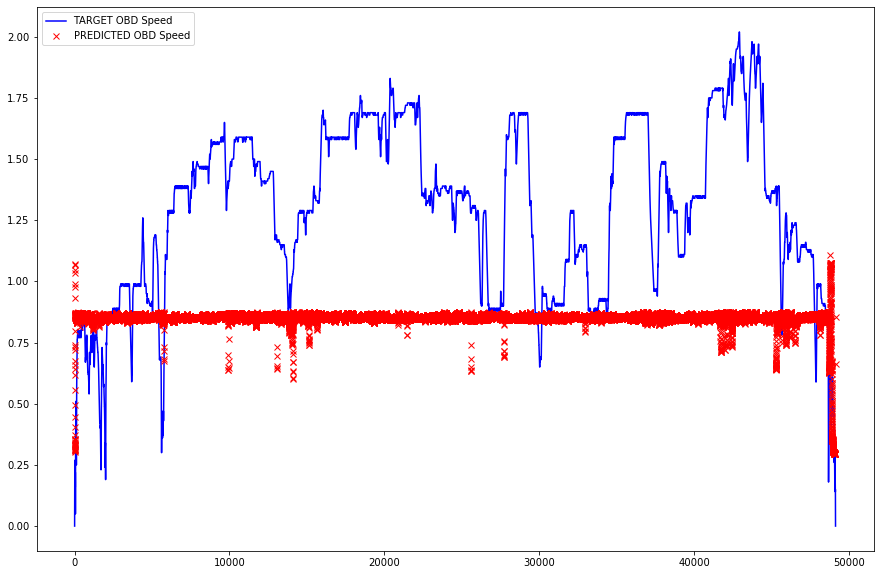

In [79]:
xaxis = range(0, len(target2))
plot.figure(figsize=(15,10))
plot.plot(xaxis, scaled_target2, 'b', xaxis, model2.predict(scaled_data2.reshape(*np.shape(scaled_data2), 1)), 'rx')
plot.legend(['TARGET OBD Speed','PREDICTED OBD Speed'])

Ab hier Überbleibsel von vorherigem Test, schien mir aber keine wirklich neuen Erkenntnisse zu liefern und wurde daher mit anderer Architektur nicht weiter verfolgt.

---

Wie auch Regression Trees scheinen unbekannte Geschwindigkeiten starke Probleme zu machen, von daher nochmal (vgl. anderes Notebook)

In [35]:
model3 = tf.keras.Sequential([
    layers.Lambda(lambda x: x, batch_input_shape = (1, np.shape(data)[1], 1)),
    layers.LSTM(128, stateful = True),
    layers.Reshape((1, 128)),
    layers.LSTM(64, stateful = True),
    layers.Dense(1)
])

model3.compile(optimizer = tf.keras.optimizers.Adam(0.001),
             loss = 'mse',
             metrics = ['mae'])

In [36]:
model3.fit(np.array(scaled_data2).reshape(*np.shape(scaled_data2), 1), np.array(scaled_target2).reshape(len(scaled_data2), 1),
           epochs = 10, batch_size = 1)

Train on 49135 samples
Epoch 1/10
49135/49135 [==============================] - 1888s 38ms/sample - loss: 0.0782 - mae: 0.2148
Epoch 2/10
49135/49135 [==============================] - 1858s 38ms/sample - loss: 0.0248 - mae: 0.1156
Epoch 3/10
49135/49135 [==============================] - 1853s 38ms/sample - loss: 0.0158 - mae: 0.0902
Epoch 4/10
49135/49135 [==============================] - 1849s 38ms/sample - loss: 0.0118 - mae: 0.0762
Epoch 5/10
49135/49135 [==============================] - 1917s 39ms/sample - loss: 0.0090 - mae: 0.0650
Epoch 6/10
49135/49135 [==============================] - 2046s 42ms/sample - loss: 0.0074 - mae: 0.0580
Epoch 7/10
49135/49135 [==============================] - 2023s 41ms/sample - loss: 0.0071 - mae: 0.0556
Epoch 8/10
49135/49135 [==============================] - 1841s 37ms/sample - loss: 0.0058 - mae: 0.0501
Epoch 9/10
49135/49135 [==============================] - 1982s 40ms/sample - loss: 0.0053 - mae: 0.0477
Epoch 10/10
49135/49135 [=======

In [37]:
SETUP_ID_3 = 888

reader3 = runsql('select * from computeddata where setup_id = {} order by distance asc'.format(SETUP_ID_3))
reader_data3 = list(reader3)

In [38]:
data3 = []
target3 = []
for row in reader_data3:
    data3 += [[float(row[c]) if row[c] != '' else math.nan for c in DATA_COLUMNS]]
    target3 += [float(row[TARGET_COLUMN]) if row[TARGET_COLUMN] != '' else math.nan]

In [39]:
data3 = imp.transform(data3)

In [40]:
scaled_data3 = scaler.transform(data3)
scaled_target3 = np.multiply(target3, 0.01)

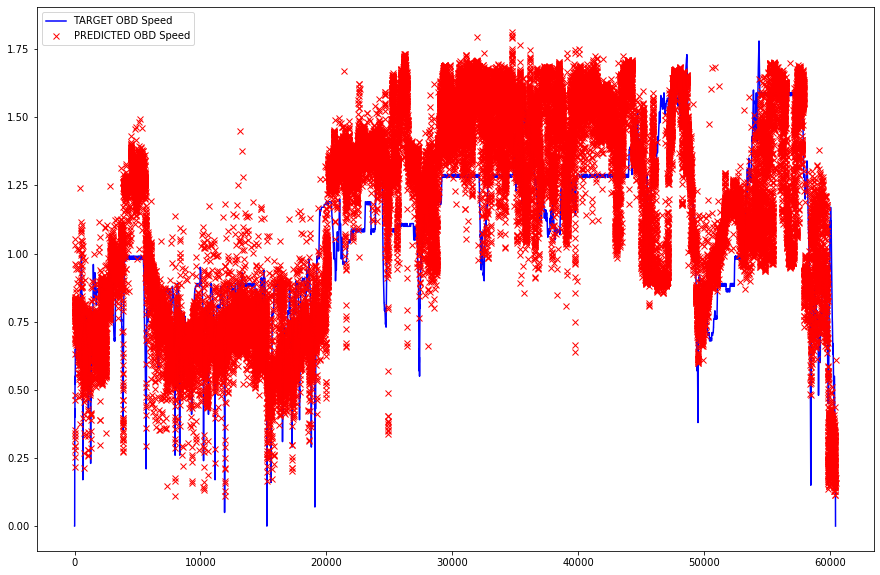

In [41]:
xaxis = range(0, len(target3))
plot.figure(figsize=(15,10))
plot.plot(xaxis, scaled_target3, 'b', xaxis, model3.predict(scaled_data3.reshape(*np.shape(scaled_data3), 1)), 'rx')
plot.legend(['TARGET OBD Speed','PREDICTED OBD Speed'])

In [42]:
ta = target3
pr = np.squeeze(np.multiply(model3.predict(scaled_data3.reshape(*np.shape(scaled_data3), 1)), 100))
RMSE = np.sqrt(sum((ta-pr)**2)/len(ta))
print("RMSE  = %.2f km/h" %RMSE)
NRMSE = 1-math.sqrt(sum((ta-pr)**2))/math.sqrt(sum( (ta-np.mean(ta) )**2 ))
print("NRMSE = %.2f %%" %(NRMSE*100))
MAE = sum(((ta-pr)**2)**(1/2))/len(ta)
print("MAE   = %.2f km/h" %MAE)
with np.errstate(divide = 'ignore'): map_elements = np.abs((ta - pr) / ta)
map_elements[map_elements == np.inf] = 0
MAP = np.sum(map_elements) / len(ta)
print("MAP   = %.2f %%" % (MAP*100))
SMAPE = np.sum(np.abs(ta - pr) / ((ta + pr) / 2)) / len(ta)
print("SMAPE = %.2f %%" % (SMAPE*100))
MSD = np.sum(ta - pr) / len(ta)
print("MSD   = %.2f km/h" % MSD)
CORR = np.corrcoef(ta, pr)[1][0]
print("CORR  = %.2f" % CORR)
ACC_A_THRESHOLD = 10
ACC_A = (np.abs(ta - pr) < ACC_A_THRESHOLD).sum() / len(ta)
print("ACC_A = %.2f %%" % (ACC_A*100))
ACC_R_THRESHOLD = 0.1
ACC_R = (np.abs(ta / pr - 1) < ACC_R_THRESHOLD).sum() / len(ta)
print("ACC_R = %.2f %%" % (ACC_R*100))
MAD = np.median(np.abs(ta - pr))
print("MAD   = %.2f km/h" % MAD)

RMSE  = 26.72 km/h
NRMSE = 6.82 %
MAE   = 22.02 km/h
MAP   = 21.77 %
SMAPE = 20.89 %
MSD   = -5.56 km/h
CORR  = 0.70
ACC_A = 24.34 %
ACC_R = 24.88 %
MAD   = 19.98 km/h


In [44]:
ta = target3
pr = [d['hr_traficSpeed'] for d in reader_data3] #t['hr_traficSpeed']
pr = np.array([float(d) if d != '' else 0.0 for d in pr])
pr = pr * 3.6
RMSE = math.sqrt(sum((ta-pr)**2)/len(ta))
print("RMSE  = %.2f km/h" %RMSE)
NRMSE = 1-math.sqrt(sum((ta-pr)**2))/math.sqrt(sum( (ta-np.mean(ta) )**2 ))
print("NRMSE = %.2f %%" %(NRMSE*100))
MAE = sum(((ta-pr)**2)**(1/2))/len(ta)
print("MAE   = %.2f km/h" %MAE)
with np.errstate(divide = 'ignore'): map_elements = np.abs((ta - pr) / ta)
map_elements[map_elements == np.inf] = 0
MAP = np.sum(map_elements) / len(ta)
print("MAP   = %.2f %%" % (MAP*100))
SMAPE = np.sum(np.abs(ta - pr) / ((ta + pr) / 2)) / len(ta)
print("SMAPE = %.2f %%" % (SMAPE*100))
MSD = np.sum(ta - pr) / len(ta)
print("MSD   = %.2f km/h" % MSD)
CORR = np.corrcoef(ta, pr)[1][0]
print("CORR  = %.2f" % CORR)
ACC_A_THRESHOLD = 10
ACC_A = (np.abs(ta - pr) < ACC_A_THRESHOLD).sum() / len(ta)
print("ACC_A = %.2f %%" % (ACC_A*100))
ACC_R_THRESHOLD = 0.1
ACC_R = (np.abs(ta / pr - 1) < ACC_R_THRESHOLD).sum() / len(ta)
print("ACC_R = %.2f %%" % (ACC_R*100))
MAD = np.median(np.abs(ta - pr))
print("MAD   = %.2f km/h" % MAD)

RMSE  = 21.57 km/h
NRMSE = 24.75 %
MAE   = 16.79 km/h
MAP   = 14.52 %
SMAPE = 15.78 %
MSD   = 12.98 km/h
CORR  = 0.81
ACC_A = 42.47 %
ACC_R = 35.90 %
MAD   = 12.00 km/h
